In [6]:
import pandas as pd 
import numpy as np 
df1=pd.read_csv('tmdb_5000_credits.csv')
df2=pd.read_csv('tmdb_5000_movies.csv')

In [ ]:
df1.columns = ['id','tittle','cast','crew']
df2= df2.merge(df1,on='id')
df2.head(5)

In [15]:
C= df2['vote_average'].mean()
m= df2['vote_count'].quantile(0.85)

In [16]:
q_movies = df2.copy().loc[df2['vote_count'] >= m]
def weighted_rating(x, m=m, C=C):
    v = x['vote_count']
    R = x['vote_average']
    # Calculation based on the IMDB formula
    return (v/(v+m) * R) + (m/(m+v) * C)
  
q_movies['score'] = q_movies.apply(weighted_rating, axis=1)


In [52]:
q_movies = q_movies.sort_values('score', ascending=False)

#Print the top 15 movies
q_movies[['title', 'vote_count', 'vote_average', 'score']].head(10)

,title,vote_count,vote_average,score
1881,The Shawshank Redemption,8205,8.5,8.170528
662,Fight Club,9413,8.3,8.031958
3232,Pulp Fiction,8428,8.3,8.004820
65,The Dark Knight,12002,8.2,7.993903
3337,The Godfather,5893,8.4,7.982719
96,Inception,13752,8.1,7.926504
809,Forrest Gump,7927,8.2,7.902889
95,Interstellar,10867,8.1,7.885368
329,The Lord of the Rings: The Return of the King,8064,8.1,7.821125
1990,The Empire Strikes Back,5879,8.2,7.818138


Text(0.5, 1.0, 'Popular Movies')

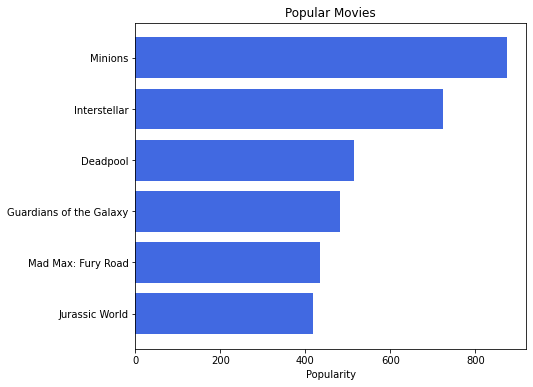

In [33]:
pop= df2.sort_values('popularity', ascending=False)
import matplotlib.pyplot as plt
plt.figure(figsize=(7,6))

plt.barh(pop['title'].head(6),pop['popularity'].head(6), align='center',
        color='royalblue')
plt.gca().invert_yaxis()
plt.xlabel("Popularity")
plt.title("Popular Movies")

In [38]:
df2[['title','overview']].head(5)

,title,overview
0,Avatar,"In the 22nd century, a paraplegic Marine is di..."
1,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha..."
2,Spectre,A cryptic message from Bond’s past sends him o...
3,The Dark Knight Rises,Following the death of District Attorney Harve...
4,John Carter,"John Carter is a war-weary, former military ca..."


In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(stop_words='english')
df2['overview'] = df2['overview'].fillna('')
tfidf_matrix = tfidf.fit_transform(df2['overview'])

<1x20978 sparse matrix of type '<class 'numpy.float64'>'
	with 15 stored elements in Compressed Sparse Row format>

In [43]:
from sklearn.metrics.pairwise import linear_kernel
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

indices = pd.Series(df2.index, index=df2['title']).drop_duplicates()

In [45]:
def get_recommendations(title, cosine_sim=cosine_sim):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]
    movie_indices = [i[0] for i in sim_scores]
    return df2['title'].iloc[movie_indices]

In [56]:
get_recommendations('The Lord of the Rings: The Return of the King')

330                 The Lord of the Rings: The Two Towers
262     The Lord of the Rings: The Fellowship of the Ring
111                                          Transformers
22                    The Hobbit: The Desolation of Smaug
3733                                          Night Watch
3622                         Once Upon a Time in the West
4400                                             Sparkler
2027                                             I Am Sam
50                    Prince of Persia: The Sands of Time
3560                                                Ouija
Name: title, dtype: object

In [62]:
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate, KFold
reader = Reader()
ratings = pd.read_csv('ratings_small.csv')
ratings.sample(5).to_latex(index=False)

'\\begin{tabular}{rrrr}\n\\toprule\n userId &  movieId &  rating &   timestamp \\\\\n\\midrule\n    564 &     3587 &     4.0 &   974708959 \\\\\n    547 &     8137 &     3.5 &  1349826122 \\\\\n    564 &     2415 &     4.0 &   974843091 \\\\\n    232 &     1227 &     5.0 &   955089443 \\\\\n    603 &      648 &     3.0 &   868354978 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [66]:
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
kf = KFold(n_splits=5)
kf.split(data)

svd = SVD()
cross_validate(svd, data, measures=['RMSE', 'MAE'])

{'fit_time': (4.991070985794067,
  5.043245077133179,
  4.958687782287598,
  4.946274280548096,
  4.937475919723511),
 'test_mae': array([0.69688366, 0.68797233, 0.68627531, 0.69626243, 0.68612008]),
 'test_rmse': array([0.90232686, 0.89763754, 0.88984471, 0.90117854, 0.89564875]),
 'test_time': (0.27805471420288086,
  0.14487934112548828,
  0.256697416305542,
  0.14426970481872559,
  0.14215850830078125)}

In [67]:
trainset = data.build_full_trainset()
svd.fit(trainset)

In [83]:
us1 = ratings[ratings['userId'] == 1]

In [84]:
svd.predict(1, 302, 3)

Prediction(uid=1, iid=302, r_ui=3, est=2.7804547721969706, details={'was_impossible': False})

In [85]:
df1[df1['movie_id']==302]

,movie_id,title,cast,crew
3303,302,Swimming Pool,"[{""cast_id"": 4, ""character"": ""Sarah Morton"", ""...","[{""credit_id"": ""52fe4234c3a36847f800c159"", ""de..."
